# Importing the necessary packages



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from tifffile import imsave

import cv2

from pathlib import Path, PosixPath
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import torch_snippets
from torch_snippets import optim, Report
from torchsummary import summary


import monai
from monai.losses import DiceLoss
from torchmetrics import JaccardIndex

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [3]:
import sys

sys.path.append('../')
sys.path.append('../utilities')
from utilities.utils import * 

In [4]:
# Setting random seed for reproducibility
seed_num = 420
np.random.seed(seed_num)

## 1. Importing the Dataset

In [5]:
experiment_number = 'Experiment_1'

In [6]:
train_folder_path = 'Experiments/' + experiment_number + '/train'
train_ground_truth_path = 'Experiments/'+ experiment_number +'/train_ground_truth'

val_folder_path = 'Experiments/' + experiment_number + '/val'
val_ground_truth_path = 'Experiments/' + experiment_number + '/val_ground_truth'

test_folder_path = 'Experiments/test'
test_ground_truth_path = 'Experiments/test_ground_truth'


train_image_paths, train_ground_truth_paths,  train_image_files, train_ground_truth_files = setup_image_paths(train_folder_path, 
                                                                                      train_ground_truth_path)

val_image_paths, val_ground_truth_paths,  val_image_files, val_ground_truth_files = setup_image_paths(val_folder_path, 
                                                                                      val_ground_truth_path)

test_image_paths, test_ground_truth_paths,  test_image_files, test_ground_truth_files = setup_image_paths(test_folder_path, 
                                                                                      test_ground_truth_path)

In [7]:
train_input_images = load_images_as_tensors(train_image_paths)
train_ground_truth_images = load_images_as_tensors(train_ground_truth_paths)

val_input_images = load_images_as_tensors(val_image_paths)
val_ground_truth_images = load_images_as_tensors(val_ground_truth_paths)

test_input_images = load_images_as_tensors(test_image_paths)
test_ground_truth_images = load_images_as_tensors(test_ground_truth_paths)

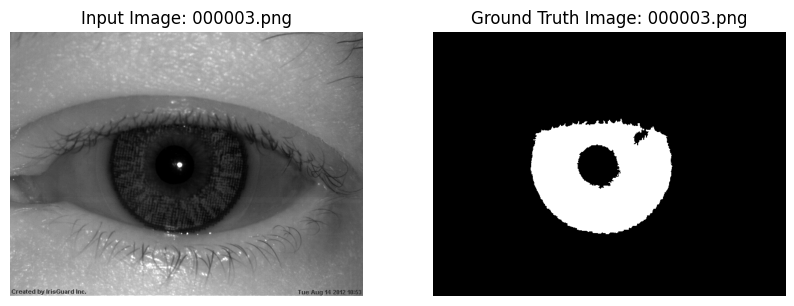

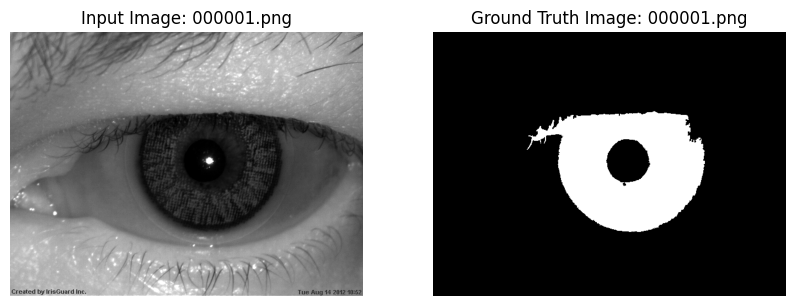

In [8]:
plot_image_tensors(train_input_images=train_input_images,
            train_ground_truth_images=train_ground_truth_images,
            image_names = train_image_files,
            index=0)


plot_image_tensors(train_input_images=test_input_images,
            train_ground_truth_images=test_ground_truth_images,
            image_names = test_image_files,
            index=0)

## 2. Creating the DataLoader

In [9]:
class IrisDataset(Dataset):
    def __init__(self, input_images, ground_truth_images):
        """
        Args:
            input_images (list of torch.Tensor): List of input image tensors.
            ground_truth_images (list of torch.Tensor): List of ground truth image tensors.
        """
        self.input_images = input_images
        self.ground_truth_images = ground_truth_images

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        ground_truth_image = self.ground_truth_images[idx]
        return input_image, ground_truth_image

# Create dataset classes
train_dataset = IrisDataset(train_input_images, train_ground_truth_images)
val_dataset = IrisDataset(val_input_images, val_ground_truth_images)
test_dataset = IrisDataset(test_input_images, test_ground_truth_images)

# Create data loaders (note that they were already shuffled in notebook 1_Creating_Datasets)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False) 
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([4, 1, 480, 640])
Labels shape =>  torch.Size([4, 1, 480, 640])


# 3. Defining the U-NET Arquitecture;

Let us first define some methods to help us:

- **up_conv:** Implements our **ConvTranspose2d** convolutions, responsible for upsampling our features in the decoder;
- **Conv:** Implements our **Conv2D** in decoders;
- **init_weights:** Initializes our model's parameters, using Xavier uniform for convolution's weights and setting biases to 0.01.

In [11]:
# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

Now, the class UNet defines our U-Net architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (block1, block2, and block3), our bottleneck, and finally, our decoder (up_convs + dec_convs and the pred convolution, which outputs our segmentation mask);
2. Our **forward** method is responsible for passing the input image through the model architecture until we get the parasite egg's mask at the end;
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection;
4. **save_curves** will save the learning curves of our models at the end of our training loop.

To initialize a U-Net model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]). Those values are used to define both encoder and decoder convolutional blocks;
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate into that folder to visualize what kind of features the model is extracting.

In [12]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        
        # Sets torch seed to guaratee Reproducibility
        random_seed = 420
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.BatchNorm2d(n_kernels[0]),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.BatchNorm2d(n_kernels[1]),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[1], out_channels=n_kernels[2],
                kernel_size=kernel_sizes[2],
                padding=kernel_sizes[2] // 2
            ),
            nn.BatchNorm2d(n_kernels[2]),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=1, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        x3 = self.block3(x2)
        self.activations["encoder"].append(x3)
        
        # Bottleneck
        bottleneck = self.bottleneck(x3)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.image_transforms(Image.open(image_path))
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

# 4. Creating the Training Loop

In [13]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=False, batch=False),
}

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our U-Net model;
- A data loader;
- The name of our loss_function (e.g., "mse", "bce");
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;

> The N_SAVE_ACTIVATIONS variable controls when we save our convolution activations. For instance, currently, it writes activations for every 100 epochs.

In [14]:
N_SAVE_ACTIVATIONS = 100

def train_loop(epochs, model, dataloader, lr, loss_function):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    logger = Report(epochs)

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = torch.sigmoid(prediction)
            loss_value = loss_function(prediction, ground_truth)

            accuracy = ((prediction > 0.5) == ground_truth).float().mean()
            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        
        logger.record(epoch + 1,
                      trn_loss=mean_loss.item(),
                      trn_accuracy=mean_acc.item()
                      )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

# 6. Run a training experiment and test our model.

First, we create our model to train. It will use kernel size seven and have an architecture equal to the U-Net image we showed previously.

In [15]:
DATA_PATH = 'UNet_Activations'

In [16]:
# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[16, 32, 64],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    activations_path=DATA_PATH / Path("exper/ksize_{}_full_data".format(kernel_size))).to(DEVICE)

Then, we run our training loop, using the training data loader defined before:

In [17]:
train_loop(
    epochs=100,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-3,
    loss_function=loss_fuctions["bce"]
)

RuntimeError: Given groups=1, weight of size [16, 3, 7, 7], expected input[4, 1, 480, 640] to have 3 channels, but got 1 channels instead

Finally, we run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

In [ ]:
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)

[INFO] Training Metrics


76it [00:00, 131.56it/s]

[INFO] Avg Accuracy: 0.9988444447517395 +/- 0.0012184171937406063
[INFO] Avg Dice: 0.8693945365605377 +/- 0.29992473422050514
[INFO] Avg IoU: 0.8471666707804328 +/- 0.2957838131746465


## 5. Define a testing loop

First, we import necessary libraries

The cells below define a method to use our trained model and predict a segmentation map. We also compute metrics between the prediction map and the ground truth. The following metrics were used:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html);
- [Dice](http://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy.metric.binary.dc);
- [Intersection-over-Union](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html), also know as jaccard_index.

> It will also save the predictions to the folder where activations of our model are saved.

In [ ]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=2, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(Image.open(image_path))
        ground_truth = data_loader.dataset.label_transforms(ImageOps.grayscale(Image.open(label_path)))
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data)
        prediction = torch.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy().squeeze()
        mask[prediction > 0.5] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        
        # Verifies if there is parasite eggs on images
        if np.any(ground_truth > 0):
            dice = binary.dc(mask, ground_truth)
            dices.append(dice)
            iou = jaccard_index(torch.Tensor(mask).long(), torch.Tensor(ground_truth).long())
            
            ious.append((iou.numpy()))
        else: 
            # If there is no parasite and our model predicted it, dice and iou equals 0
            if np.any(mask > 0):
                dices.append(0)
                ious.append(0)
            # If there is no parasite and our model do not predicted it, dice and iou equals 1 (100%)
            else:
                dices.append(1)
                ious.append(1)
                
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)
    
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

In [ ]:
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Test Metrics


20it [00:00, 136.26it/s]

[INFO] Avg Accuracy: 0.9927664995193481 +/- 0.008721794933080673
[INFO] Avg Dice: 0.5509991712905213 +/- 0.44533388531853435
[INFO] Avg IoU: 0.5109040597453713 +/- 0.42797194171927655


As we saw previously, Dice and IoU scores are more suitable for assessing segmentation performance. By analyzing those metrics, we see that our model performed better on training data than on testing data. This behavior suggests overfitting, where the model learns its parameters to adjust to the training data and cannot generalize well to unseen data. To solve this problem, we have some approaches. Examples are:

- We could simplify our model so it does not learn a function that over-adjusts to the training data;
- We could implement augmentations on our training data, increasing the training size. By feeding different images, we could force our model to learn more discriminative images. We will learn about augmentations in the classification notebooks.

Finally, we could visualize activations generated by our convolutional blocks. Below there is an example of activation for the image 000001.png.

![](layer_1_ch_11.png)

> Navigate to your activations folder (at ../data/parasites/exper/ksize_7_full_data/epoch_399), and visualize additional activations.

# Extra - Activities

- Experiment simplifying your model (less filters and smaller filters) an verify your results.
    - Explore different size of kernels and visualize model's activations and improvements on performance metrics
    - Explore different number of kernels and visualize model's activation and improvements on performance metrics
- Explore different losses, and classes' weights to improve performance metrics (DICE and IoU)